## Reference to Report Section

The code implements a Random Forest model demo to predict song popularity and subsequently uses these predictions to infer an artist's future influence. This approach aligns with the report's analysis:

> "A highly effective Random Forest model was selected based on its strong predictive capabilities in identifying popular songs and robust cross-validation results. Leveraging these predictions, the experiment explored whether the future popularity of certain old or simulated new songs could be used to infer the sustained popularity of their creators—namely, the artists themselves. The underlying assumption is that an artist's ability to produce or inspire trending songs strongly correlates with their ongoing prominence in the music industry. This approach offers a practical framework for forecasting artist future influence."


### step 0：import processed data

In [1]:
import pandas as pd
import numpy as np

file_path = 'Processed_Spotify_Dataset.csv'
spotify_data = pd.read_csv(file_path)

spotify_data.describe()

,Rank,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,Valence,Artist (Ind.),Nationality,Continent,Points (Total),Points (Ind for each Artist/Nat),Lag_Points
count,651963.000000,651963.000000,651963.000000,651963.000000,651963.000000,651963.000000,651963.000000,651963.000000,651963.000000,651963.000000,651963.000000,651963.000000,651963.000000,651963.000000
mean,100.406333,0.697730,0.652055,0.810895,0.109943,0.230695,0.007647,0.523148,1043.629152,53.991489,2.265400,100.593667,72.391381,99.899703
std,57.407350,0.133183,0.155684,0.077403,0.096840,0.230705,0.054723,0.223932,634.505775,23.460988,1.347108,57.407350,54.227081,56.603194
min,1.000000,0.073000,0.005000,0.000000,0.022000,0.000000,0.000000,0.026000,0.000000,0.000000,0.000000,1.000000,0.200000,0.369004
25%,51.000000,0.617000,0.549000,0.768397,0.045000,0.048000,0.000000,0.356000,493.000000,44.000000,1.000000,51.000000,28.000000,50.586716
50%,100.000000,0.719000,0.671000,0.813250,0.068000,0.152000,0.000000,0.521000,998.000000,70.000000,2.000000,101.000000,60.000000,99.169742
75%,150.000000,0.793000,0.771000,0.850058,0.136000,0.349000,0.000000,0.696000,1585.000000,71.000000,4.000000,150.000000,104.000000,148.374539
max,200.000000,0.985000,0.996000,1.000000,0.966000,0.994000,0.956000,0.982000,2207.000000,73.000000,6.000000,200.000000,200.000000,200.000000


### step 1：choose features and target

In [2]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix

In [3]:
features = ['Lag_Points', 'Danceability', 'Energy', 'Loudness', 'Speechiness',
            'Acousticness', 'Instrumentalness']

# target for regression 'Points (Total)'
# target for classification 'is_popular'
target_reg = 'Points (Total)'
spotify_data['is_popular'] = (spotify_data['Points (Total)'] > 180).astype(int)  # 构建分类标签
target_clf = 'is_popular'

### step 2: scaler and split

In [4]:
# 2017-2022 train data，2023 test data
train_data = spotify_data[spotify_data['Date'] < '2022-05-29']
test_data = spotify_data[spotify_data['Date'].between('2022-05-29', '2023-05-29')]

# extract features
X_train = train_data[features]
y_train_reg = train_data[target_reg]
y_train_clf = train_data[target_clf]

X_test = test_data[features]
y_test_reg = test_data[target_reg]
y_test_clf = test_data[target_clf]

# scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f"size of training set: {len(X_train)}, size of test set: {len(X_test)}")

size of training set: 548005, size of test set: 103958


### step3 random forest regressor demo

In [5]:
regressor = RandomForestRegressor(n_estimators=20, max_depth=5, random_state=42)

regressor.fit(X_train, y_train_reg)

y_pred_reg = regressor.predict(X_test)

mse = mean_squared_error(y_test_reg, y_pred_reg)
r2 = r2_score(y_test_reg, y_pred_reg)

print(f"random forest regressor (MSE): {mse:.2f}")
print(f"random forest regressor R² : {r2:.2f}")


random forest regressor (MSE): 190.09
random forest regressor R² : 0.94


### step4 random forest classifier demo

In [6]:
classifier = RandomForestClassifier(n_estimators=20, max_depth=5, random_state=42)

classifier.fit(X_train, y_train_clf)

y_pred_clf = classifier.predict(X_test)

accuracy = accuracy_score(y_test_clf, y_pred_clf)
conf_matrix = confusion_matrix(y_test_clf, y_pred_clf)

print(f"accuracy: {accuracy:.2f}")
print("conf_matrix:")
print(conf_matrix)

accuracy: 0.99
conf_matrix:
[[92754   359]
 [  866  9979]]


### step 5 prediction for songs and artists popularity in 2024

In [7]:

import json
from sklearn.preprocessing import LabelEncoder

# load JSON 
with open('label_encoders.json', 'r') as f:
    encoders_dict = json.load(f)

# and get label_encoders
label_encoders = {}
for key, classes in encoders_dict.items():
    le = LabelEncoder()
    le.classes_ = np.array(classes)
    label_encoders[key] = le

In [8]:
# mock dataset in 2024 （use data in 2023）
future_dates = pd.date_range(start='2024-01-01', end='2024-12-31', freq='D')
future_data = test_data.copy() 

# predict Points (Total) in 2024
future_data = future_data.iloc[:len(future_dates)] 
future_data['Date'] = future_dates
future_features = scaler.transform(future_data[features])
future_data['Predicted_Points'] = regressor.predict(future_features)

# future_data.head(10)



In [9]:
# 1 prediction at song level

future_data['Predicted_Points'] = regressor.predict(future_features)

future_data[['id', 'Artist (Ind.)', 'Date', 'Predicted_Points']].head(10)

,id,Artist (Ind.),Date,Predicted_Points
0,3qQbCzHBycnDpGskqOWY0E,617,2024-01-01,197.347879
1,3qQbCzHBycnDpGskqOWY0E,1558,2024-01-02,197.347879
2,7ro0hRteUMfnOioTFI5TG1,183,2024-01-03,197.347879
3,2UW7JaomAMuX9pZrjVpHAU,2121,2024-01-04,197.347879
4,2UW7JaomAMuX9pZrjVpHAU,1558,2024-01-05,197.347879
5,7FbrGaHYVDmfr7KoLIZnQ7,625,2024-01-06,197.347879
6,6pD0ufEQq0xdHSsRbg9LBK,734,2024-01-07,197.347879
7,6pD0ufEQq0xdHSsRbg9LBK,183,2024-01-08,197.347879
8,4DHcnVTT87F0zZhRPYmZ3B,1371,2024-01-09,197.347879
9,1odExI7RdWc4BT515LTAwj,484,2024-01-10,191.093843


In [10]:
# 2 prediction at artist level
# compute the average points for each artist
artist_predictions = future_data.groupby('Artist (Ind.)')['Predicted_Points'].mean().reset_index()
artist_predictions.columns = ['Artist (Ind.)', 'Avg_Predicted_Points']

artist_predictions.head(10)

,Artist (Ind.),Avg_Predicted_Points
0,2,90.650191
1,4,112.901040
2,8,111.971455
3,56,71.047722
4,63,98.199279
5,100,61.272423
6,102,98.199279
7,113,135.083256
8,119,141.307228
9,128,112.379802


In [11]:
# get popular artist list 

popularity_threshold = 180

artist_predictions['is_popular'] = (artist_predictions['Avg_Predicted_Points'] > popularity_threshold).astype(int)

predicted_popular_artists = artist_predictions[artist_predictions['is_popular'] == 1]['Artist (Ind.)'].unique()
original_artists = label_encoders['Artist (Ind.)'].inverse_transform(predicted_popular_artists)

print("2024 popular artist list", original_artists)

2024 popular artist list ['Ariana Grande' 'David Kushner' 'Eslabon Armado' 'FIFTY FIFTY'
 'Miley Cyrus' 'Rema' 'Selena Gomez' 'Yng Lvcas' 'Young Miko']


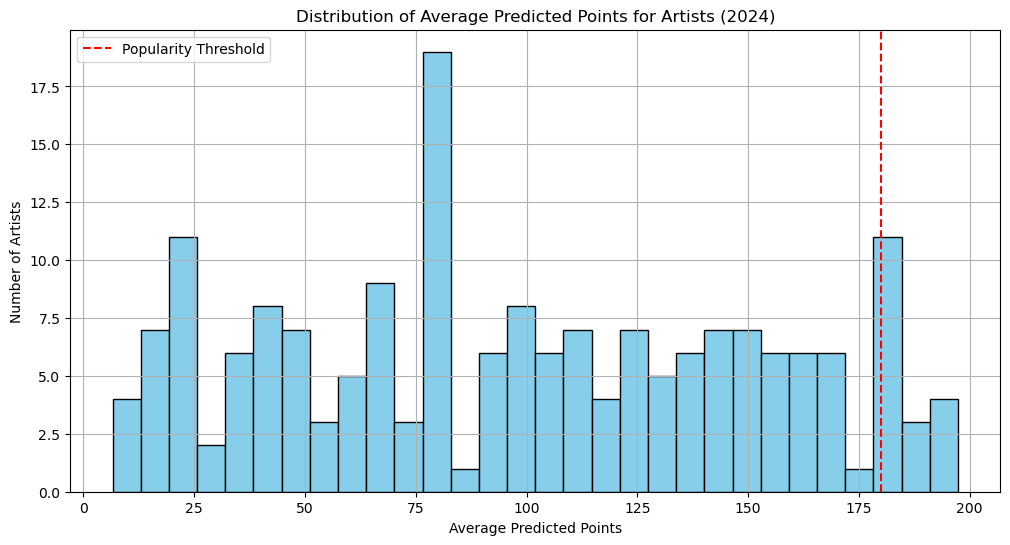

In [12]:
import matplotlib.pyplot as plt

# Visualizing the distribution of average predicted ratings for artists
plt.figure(figsize=(12, 6))
plt.hist(artist_predictions['Avg_Predicted_Points'], bins=30, color='skyblue', edgecolor='black')
plt.axvline(x=popularity_threshold, color='red', linestyle='--', label='Popularity Threshold')
plt.xlabel('Average Predicted Points')
plt.ylabel('Number of Artists')
plt.title('Distribution of Average Predicted Points for Artists (2024)')
plt.legend()
plt.grid()
plt.show()